# Graph Analysis of potential franchise excelerators
## Evaluation of the IMDB Films By Actor For 10k Actors dataset
---
<b>MADS-EMDM Portfolio-Exam Part 2<br>
Janosch Höfer, 938969</b>

## Table of contents

- [Introduction](#intro) <br>
- [1. Data Exploration](#data-prep) <br>
    - [1.1. Data Engineering](#dataeng) <br>
    - [1.2. Data Visualization](#datavis) <br>
    - [1.3. Graphs](#graphs) <br>
    - [1.4. Sub-Graphs](#subgraphs) <br>
- [2. Experiments](#exp) <br>
   - [2.1. Node-Roles](#noderoles) <br>
   - [2.2. Community-Discovery](#comdis) <br>
       - [2.2.1. Louvain Community Detection](#221) <br>
       - [2.2.2. Modularity-based communities](#222) <br>
       - [2.2.3. Fluid Communities](#223) <br>
       - [2.2.4. Girvan-Newman Communities](#224) <br>
- [3. Results](#results)<br>
- [References](#ref)<br>

## Introduction

In [1]:
# Standard libraries
import os
import itertools
import json
import random

import mplcyberpunk
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

# Own classes and functions
from helper_scripts.draw_graph import prepare_drawing, draw_graph_filtered

In [2]:
pd.set_option("display.max_columns", 25)
plt.style.use("cyberpunk")

We were commissioned by film studio Disxar DC Pictures to find potential actors who could be cast as "intermediaries" between franchises. The goal is to find actors who form the shortest link between two franchises. The hope is that these actors will have successfully taken their existing fanbase from the first franchise/movie into a new franchise/movie and therefore will be able to do the same for new films they perform in. 

---
<a id='data-prep'></a>

## 1. Data Exploration
<a id='dataeng'></a>
### 1.1. Data Engineering

The dataset used for this analysis is called IMDB Films By Actor For 10k Actors and can be found on Kaggle [[1]](https://www.kaggle.com/datasets/darinhawley/imdb-films-by-actor-for-10k-actors). The license of the dataset is CC0 and therefore dedicated to the public domain.


In [3]:
path_to_data = "data"

In [4]:
df = pd.read_csv(os.path.join(path_to_data, "actorfilms.csv"))

In [5]:
df.head()

Actor    ActorID                   Film  Year  Votes  Rating  \
0  Fred Astaire  nm0000001            Ghost Story  1981   7731     6.3   
1  Fred Astaire  nm0000001        The Purple Taxi  1977    533     6.6   
2  Fred Astaire  nm0000001  The Amazing Dobermans  1976    369     5.3   
3  Fred Astaire  nm0000001   The Towering Inferno  1974  39888     7.0   
4  Fred Astaire  nm0000001              Midas Run  1969    123     4.8   

      FilmID  
0  tt0082449  
1  tt0076851  
2  tt0074130  
3  tt0072308  
4  tt0064664

The dataset contains the IMBD ratings for the movies that the ~10.000 actors have starred in. Besides the actor and movie names it contains the year the movie was released, the number of IMDB ratings, the average IMDB rating and IDs for the actor and movie. Because the IDs will not be needed they are dropped.

In [6]:
df = df.drop(columns=["ActorID", "FilmID"])
df.duplicated().sum()

0

After dropping the ID columns, we make sure that we have not created any duplicates.

In [7]:
df.shape

(191873, 5)

The dataset has 191,873 entries.

In [8]:
print(
    f"Unique actors: {len(df['Actor'].unique()):,d} \nUnique movies: {len(df['Film'].unique()):,d}"
)

Unique actors: 9,615 
Unique movies: 41,050


The dataset contains 9,615 unique actors and 41,050 unique movies.

In [9]:
df.describe()

Year         Votes         Rating
count  191873.000000  1.918730e+05  191873.000000
mean     1997.952948  5.041857e+04       5.975764
std        19.839797  1.392857e+05       1.094434
min      1914.000000  1.000000e+02       1.000000
25%      1990.000000  6.690000e+02       5.400000
50%      2004.000000  3.906000e+03       6.100000
75%      2013.000000  3.213200e+04       6.700000
max      2021.000000  2.371548e+06       9.300000

The oldest movie is from 1914 and the newest is from 2021. 75% of all movies have been released after the yer 1990. The lowest rating is 1.0 and the highest rating 9.3.

The number of votes goes from 100 to 2,371,548, with 75% of all movies having less than 33,000 votes.

In [10]:
df_movies = df.groupby("Film")[["Year", "Votes", "Rating"]].max().reset_index()

In [11]:
df_movies.loc[df_movies["Votes"].nlargest(10).index]

Film  Year    Votes  \
35821                           The Shawshank Redemption  1994  2371548   
31364                                    The Dark Knight  2008  2335143   
15646                                          Inception  2010  2094535   
11284                                         Fight Club  1999  1876882   
24467                                       Pulp Fiction  1994  1847827   
11866                                       Forrest Gump  1994  1833787   
34200                                         The Matrix  1999  1696491   
33868  The Lord of the Rings: The Fellowship of the Ring  2001  1680215   
33869      The Lord of the Rings: The Return of the King  2003  1660358   
32408                                      The Godfather  1972  1642278   

       Rating  
35821     9.3  
31364     9.0  
15646     8.8  
11284     8.8  
24467     8.9  
11866     8.8  
34200     8.7  
33868     8.8  
33869     8.9  
32408     9.2

The ten movies with the most ratings are most often released in the 90s and early 2000s. The Godfather (1972), The Dark Knight (2008) and Inception (2010) are the exception.

In [12]:
df_movies.loc[df_movies["Rating"].nlargest(10).index]

Film  Year    Votes  \
35821                           The Shawshank Redemption  1994  2371548   
32408                                      The Godfather  1972  1642278   
33679                                 The Lehman Trilogy  2019      164   
4137                  Behind the Album: The Performances  2017      199   
21604  National Theatre Live: Angels in America Part ...  2017      378   
123                                         12 Angry Men  1957   699843   
24780                Ramayana: The Legend of Prince Rama  1992     2356   
31283                                       The Crucible  2014    35536   
31364                                    The Dark Knight  2008  2335143   
32410                             The Godfather: Part II  1974  1143820   

       Rating  
35821     9.3  
32408     9.2  
33679     9.2  
4137      9.1  
21604     9.1  
123       9.0  
24780     9.0  
31283     9.0  
31364     9.0  
32410     9.0

The ten Movies with the highest ratings show how a good rating does not mean that a movie is also popular. Most likely these movies are niche films with dedicated fans and small followings. In order to filter those niche movies, all movies with not enough ratings are removed from the dataset. This also decreases the size of the dataset and makes it much easier to analyse and understand.<br>
For this we create two DataFrames. One containing all movies that are above the threshold and that contains all movies with less.

In [13]:
votes_threshold = 100_000
df_movies_pop = df_movies.loc[df_movies["Votes"] >= votes_threshold].copy()
df_movies_flop = df_movies.loc[df_movies["Votes"] < votes_threshold].copy()
df_movies_pop.shape, df_movies_flop.shape

((1905, 4), (39145, 4))

We will use 100,000 as the threshold for the number of votes. This brings the total number of movies down from 41,050 to 1,905.

This reduces the number of entries in the full dataset from 191,873 to 26,126 entries.

In [14]:
df_pop = df[df["Film"].isin(df_movies_pop["Film"].tolist())]
df_pop.shape

(26126, 5)

In [15]:
df_pop["Actor"].nunique()

6647

These remaining 1,905 movies have had 6,647 actors.

<a id='datavis'></a>
### 1.2. Data Visualization 

Before we create the graphs, we will look at how much the filtering affects the distribution of the data.

In [16]:
df_movies_flop["Movie Type"] = "All"
df_movies_pop["Movie Type"] = "Popular"
df_movies_all = pd.concat([df_movies_flop, df_movies_pop])

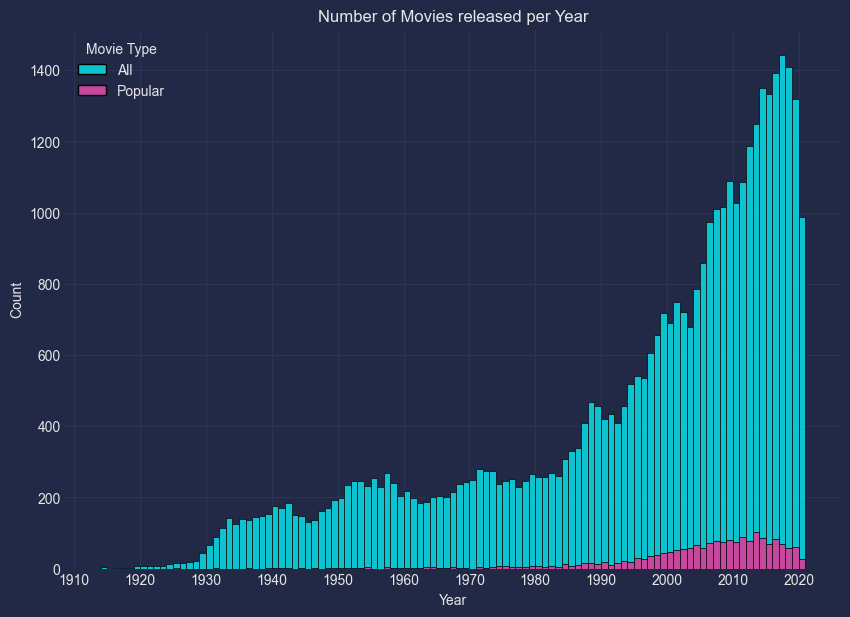

In [17]:
bins_year = df_movies_all["Year"].nunique()  # One bin for each year

plt.figure(figsize=(10, 7))
sns.histplot(data=df_movies_all, x="Year", bins=bins_year, hue="Movie Type", multiple="stack")
plt.locator_params(axis="x", nbins=20)
plt.title("Number of Movies released per Year")
plt.show()

The graph above and the one next are not stacked. The blue bar shows the total number of movies per year and the violet bar is the share that we have selected.


It can very clearly be observed that from 1985 onwards the number of movies released increased significantly. This number has decreased in the years 2020 and 2021. Most likely this is due to the fact that during those years Corona was present and many film studios had to pause their work. That is why the number of released movies for 2020 is still relatively high, because presumably many films were already in their final stages and no longer had to be shot, but only edited.<br>
Our filtered selection mostly includes more recent movies. This can have several reasons. Presumably, the IMBD site is primarily used by the Generation Y, which has grown up with the Internet. With this generation, many movies before 1990 are not so well known or popular, because these movies came out when many were not yet born. Of course, there are exceptions to this rule (see Star Wars). Another reason could be that the Internet is still very young and people tend to talk about current events and therefore newer movies have more ratings because they are still "fresh".

In [18]:
pop_votes = df_movies_pop["Votes"].sum()
flop_votes = df_movies_flop["Votes"].sum()
total_votes = pop_votes + flop_votes
f"Percentage of votes for our selected data: {pop_votes/total_votes*100:.2f}%"

'Percentage of votes for our selected data: 67.32%'

Although we consider only a very small part of the whole dataset, we map 2/3 of all votes.

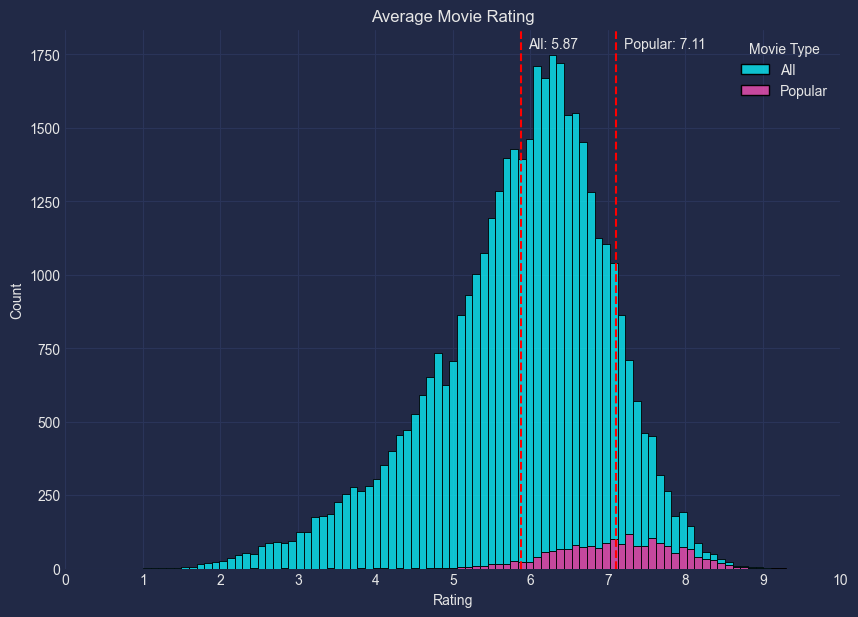

In [19]:
bins_rating = df_movies_all["Rating"].nunique()
all_rating = df_movies_all["Rating"].mean()
pop_rating = df_movies_pop["Rating"].mean()

plt.figure(figsize=(10, 7))
sns.histplot(data=df_movies_all, x="Rating", hue="Movie Type", multiple="stack", bins=bins_rating)
plt.axvline(all_rating, color="red", linestyle="--")
plt.annotate(f"All: {all_rating:.2f}", xy=(all_rating + 0.1, 1770))
plt.axvline(pop_rating, color="red", linestyle="--")
plt.annotate(f"Popular: {pop_rating:.2f}", xy=(pop_rating + 0.1, 1770))
plt.locator_params(axis="x", nbins=10)
plt.xlim(0, 10)
plt.title("Average Movie Rating")
plt.show()

Next, we see how the ratings are distributed. Contrary to my expectations, the popular movies have better average ratings then compared to the full dataset. 

<a id='graphs'></a>
### 1.3. Graphs

Next, we create a weighted graph. For this we create nodes for actors and movies and connect them when an actor has starred in a movie.

In [20]:
def add_edge(g, u, v):
    if g.has_edge(u, v):
        g[u][v]["weight"] += 1
    else:
        g.add_edge(u, v, weight=1)

In [21]:
G = nx.Graph()
for _, row in tqdm(df_pop.iterrows(), total=df_pop.shape[0]):
    add_edge(G, row["Actor"], row["Film"])

  0%|          | 0/26126 [00:00<?, ?it/s]

We then calculate the layout of the graph for the upcoming visualizations. For that we use a fixed random seed to ensure that the plots are consistent.

In [22]:
random_seed = 42

In [23]:
actors = df_pop["Actor"].unique().tolist()
actors_sizes = df_pop["Actor"].value_counts().to_dict()
movies_sizes = df_pop["Film"].value_counts().to_dict()

In [24]:
def create_pos(G, actors, random_seed, safe=True):
    if not safe:
        return prepare_drawing(G.to_undirected(), actors, random_seed=random_seed)
    try:
        with open(os.path.join(path_to_data, "pos.json"), "r") as f:
            pos = json.load(f)
        actor_nodes = pd.read_csv(f"{path_to_data}/actor_nodes.csv", index_col=0)["0"].to_list()
        movie_nodes = pd.read_csv(f"{path_to_data}/movie_nodes.csv", index_col=0)["0"].to_list()
    except FileNotFoundError:
        print("Files not found, creating new positions and nodes...")
        pos, actor_nodes, movie_nodes = prepare_drawing(
            G.to_undirected(), actors, random_seed=random_seed
        )
        with open(f"{path_to_data}/pos.json", "w") as f:
            json.dump({node: tuple(coords) for node, coords in pos.items()}, f)
        pd.Series(actor_nodes).to_csv(os.path.join(path_to_data, "actor_nodes.csv"))
        pd.Series(movie_nodes).to_csv(os.path.join(path_to_data, "movie_nodes.csv"))
    return pos, actor_nodes, movie_nodes


pos, actor_nodes, movie_nodes = create_pos(G, actors, random_seed)

Files not found, creating new positions and nodes...


DISCLAIMER: If the graphics should be too large for the screen, the size can be adjusted in the function. For this purpose the parameter figsize can be passed as input. The default size is (7,7).

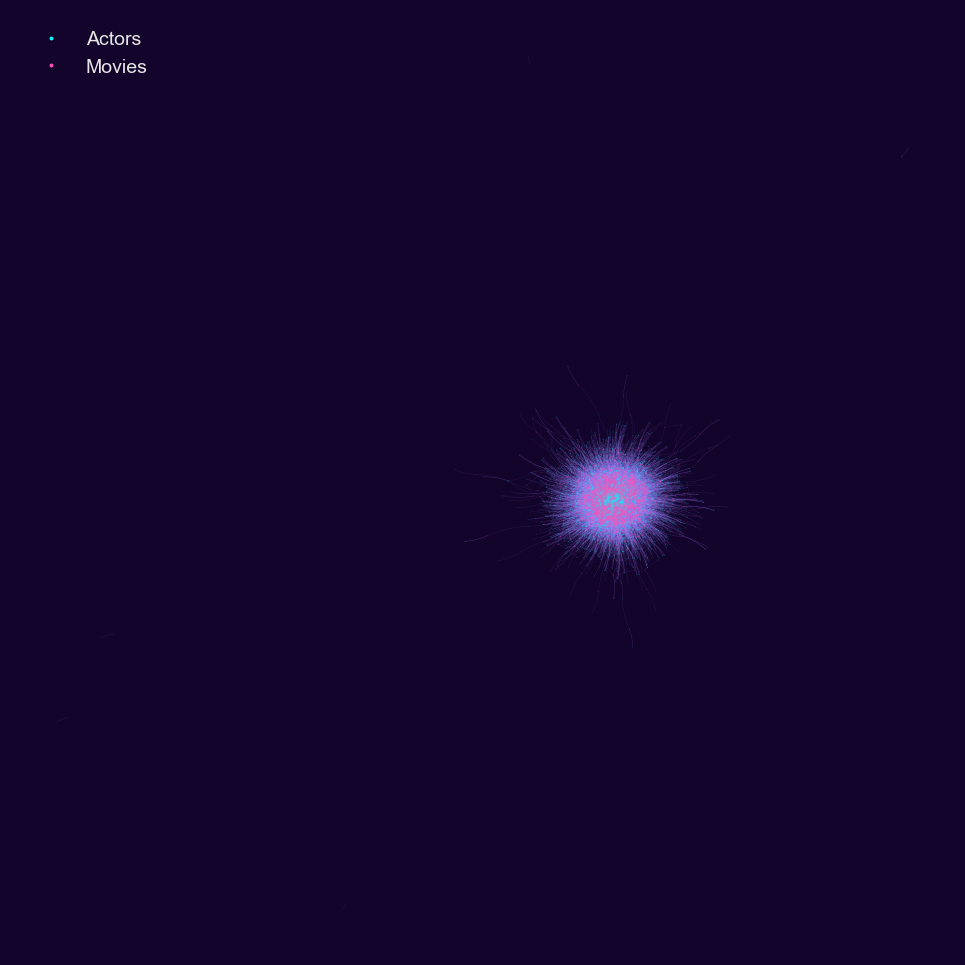

In [25]:
draw_graph_filtered(
    G,
    pos,  # previously calculated node positions
    nodes_list=[actor_nodes, movie_nodes],  # The two types of nodes
    nodes_sizes_list=[actors_sizes, movies_sizes],  # sizes of the nodes, based on occurence
    node_size_reduction_factor=10,
    edge_linewidth_reduction_factor=5,
    min_sizes=[1, 1],  # Minimum size of nodes to be displayed
    min_sizes_labels=[20, 20],  # Minimum size of nodes to display labels
    node_alpha=0.3,
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=1,
)

As soon as we plot the entire graph, we immediately realize that we can not see anything on the image. A very large blob can be seen, which is made up of most of the nodes, and on the right edge of the image very small islands of a few nodes an be seen. These small islands are movies with actors who are not in any other movie from our dataset.

In [26]:
nx.is_connected(G)

False

This is confirmed because the graph is not strongly connected.

In [27]:
list(nx.isolates(G))

[]

We don't have isolated nodes, those are nodes without an edge, because our creation method is based on connections between actors and movies. We only have movies with actors and only actors with movies.

To get rid of the isolated groups and make our graph strongly connected, we create the giant connected component (GCC) which contains largest component, the maximal connected induced subgraph.

In [28]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

In [29]:
nx.is_connected(G0)

True

In [30]:
G.number_of_nodes(), G0.number_of_nodes()

(8552, 8540)

The GCC has only 12 Nodes less.

In [31]:
G0_nodes = [node for node in G0.nodes]
missing_nodes = [node for node in G.nodes if node not in G0_nodes]
df_pop[df_pop["Film"].isin(missing_nodes)]

Actor                      Film  Year   Votes  Rating
50715      Toshiro Mifune                   Yojimbo  1961  112737     8.2
50733      Toshiro Mifune             Seven Samurai  1954  319163     8.6
50739      Toshiro Mifune                  Rashomon  1950  154495     8.2
88470        Stephen Chow            Kung Fu Hustle  2004  128414     7.7
176844   Tamannaah Bhatia  Baahubali: The Beginning  2015  104016     8.0
179054  Katie Featherston       Paranormal Activity  2007  221833     6.3
187366         Kim Tae-ri            The Handmaiden  2016  117691     8.1

The nodes we have removed are movies that only have one actor associated with them. Two notable films here are Paranormal Activity and Kung Fu Hustle. Two rather popular movies.

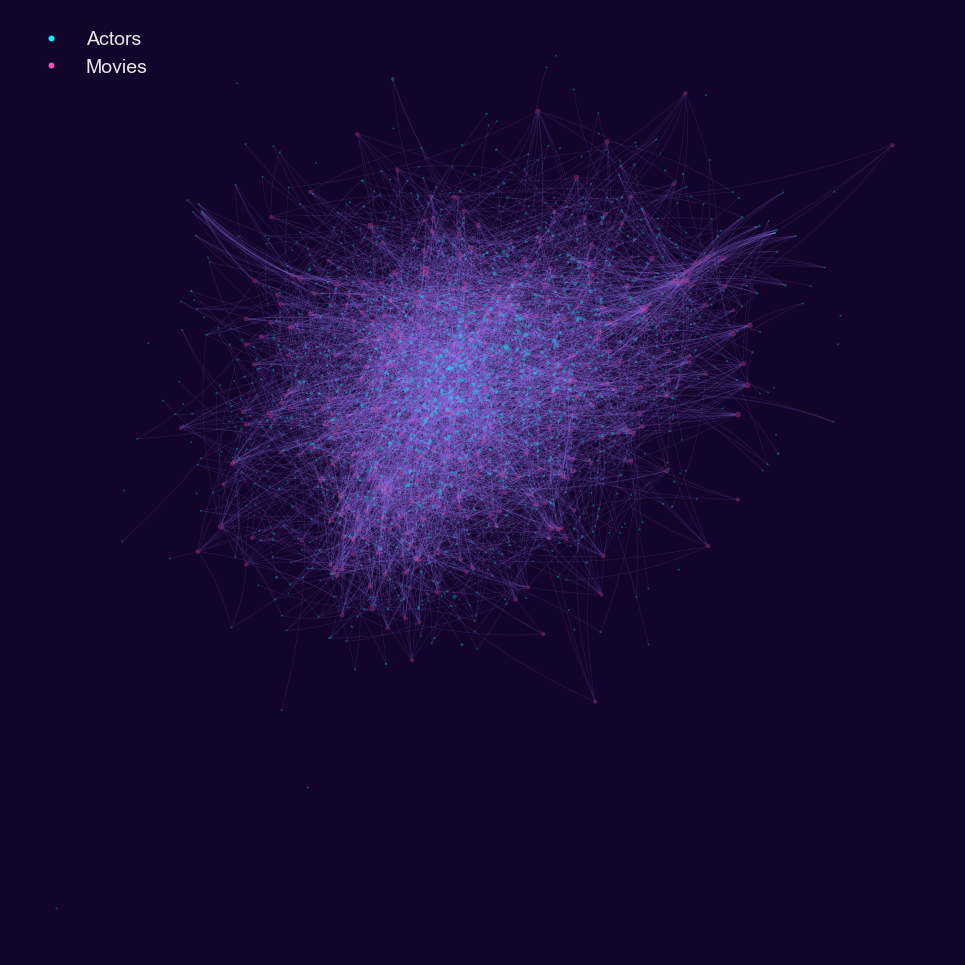

In [32]:
pos, actor_nodes, movie_nodes = create_pos(G0, actors, random_seed, safe=False)
draw_graph_filtered(
    G0,
    pos,
    nodes_list=[actor_nodes, movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    node_size_reduction_factor=5,
    edge_linewidth_reduction_factor=3,
    min_sizes=[5, 20],  # Minimum size of nodes to be displayed
    min_sizes_labels=[800, 1000],  # Minimum size of nodes to display labels
    node_alpha=0.3,
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=2,
)

After removing the disconnected nodes, the graph looks much better. But still not much can be seen in the graph.

<a id='subgraphs'></a>
### 1.4. Sub-Graphs

Because the graph with the approx. 6000 actors is still too complex, we will create some subgraphs. First, we will look at one movie. For this, we'll take the highest-rated movie by Tom Hanks: Forrest Gump.

In [33]:
df_pop[df_pop["Actor"] == "Tom Hanks"].nlargest(10, "Rating")

Actor                 Film  Year    Votes  Rating
6686  Tom Hanks         Forrest Gump  1994  1833787     8.8
6679  Tom Hanks       The Green Mile  1999  1163069     8.6
6681  Tom Hanks  Saving Private Ryan  1998  1249995     8.6
6684  Tom Hanks            Toy Story  1995   897495     8.3
6665  Tom Hanks          Toy Story 3  2010   764545     8.2
6676  Tom Hanks  Catch Me If You Can  2002   846690     8.1
6680  Tom Hanks          Toy Story 2  1999   532307     7.9
6651  Tom Hanks          Toy Story 4  2019   208751     7.8
6660  Tom Hanks     Captain Phillips  2013   425345     7.8
6678  Tom Hanks            Cast Away  2000   530674     7.8

In [34]:
sub_G = nx.ego_graph(G0, "Forrest Gump")
sub_pos, sub_actor_nodes, sub_movie_nodes = create_pos(sub_G, actors, random_seed, safe=False)

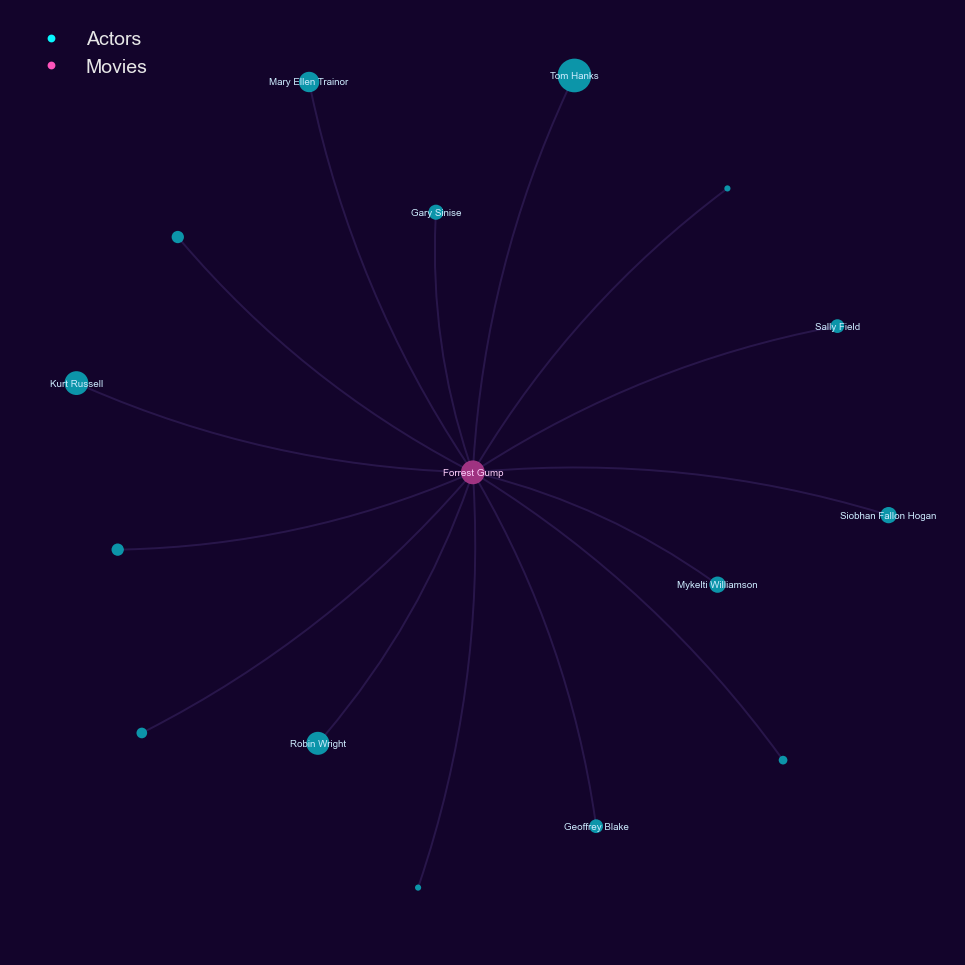

In [35]:
draw_graph_filtered(
    sub_G,
    sub_pos,
    nodes_list=[sub_actor_nodes, sub_movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    node_size_reduction_factor=0.1,
    add_labels=True,
    min_sizes=[1, 1],  # Minimum size of nodes to be displayed
    min_sizes_labels=[5, 10],  # Minimum size of nodes to display labels
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=3,
)

Here we see all the actors who starred in Forrest Gump.

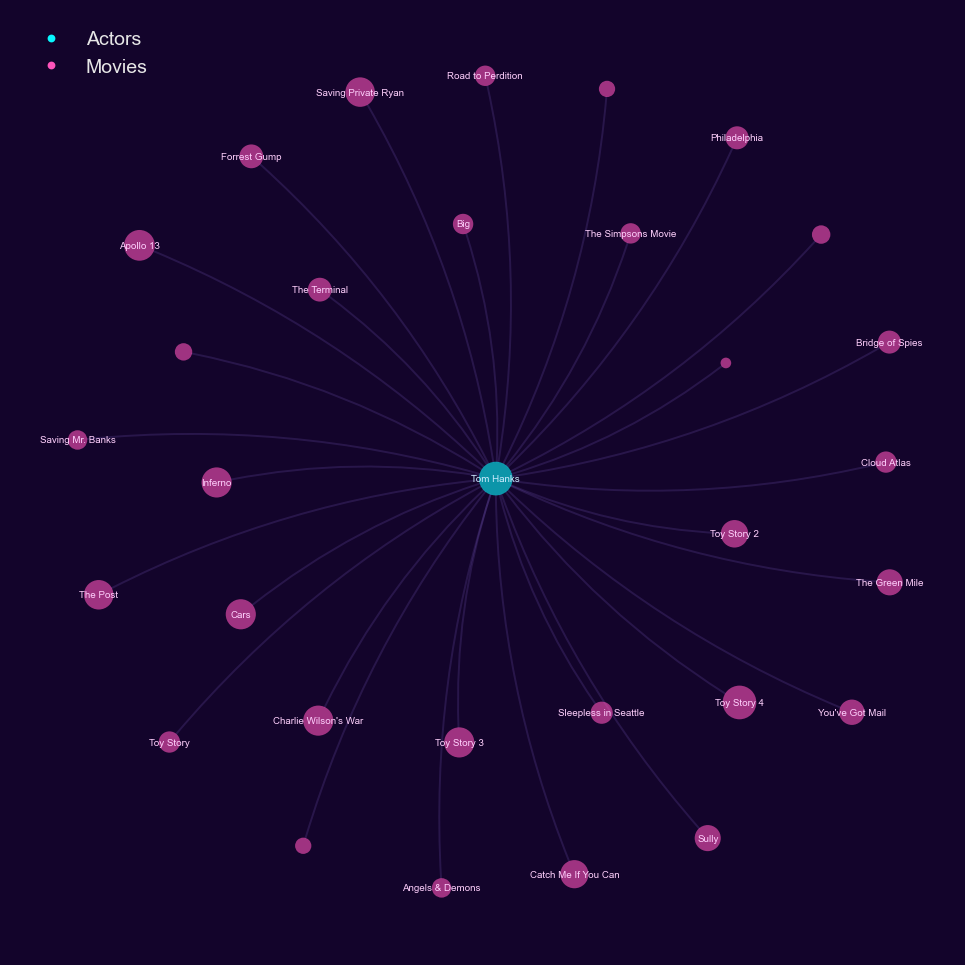

In [36]:
sub_G = nx.ego_graph(G0, "Tom Hanks")
sub_pos, sub_actor_nodes, sub_movie_nodes = create_pos(sub_G, actors, random_seed, safe=False)
draw_graph_filtered(
    sub_G,
    sub_pos,
    nodes_list=[sub_actor_nodes, sub_movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    node_size_reduction_factor=0.1,
    add_labels=True,
    min_sizes=[1, 1],  # Minimum size of nodes to be displayed
    min_sizes_labels=[5, 10],  # Minimum size of nodes to display labels
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=3,
)

We can do the same for movies that Tom Hanks has starred in. We can see that he has been in a lot of movies. 

These subgraphs are much clearer, but have no more information than a table. Therefore, we want to choose a different approach to create a subgraph. We further reduce our dataset by looking at only the 50 movies with the most ratings.

In [37]:
n_votes = 50
top_n_movies = df_movies_pop.loc[df_movies_pop["Votes"].nlargest(n_votes).index]["Film"].to_list()
top_actors = list(df_pop[df_pop["Film"].isin(top_n_movies)]["Actor"].unique())

In [38]:
top_n_votes = df_movies_pop.loc[df_movies_pop["Votes"].nlargest(n_votes).index]["Votes"].sum()
f"Percentage of total data: {top_n_votes/total_votes*100:.2f}%"

'Percentage of total data: 8.28%'

In [39]:
f"Percentage of selected data: {top_n_votes/pop_votes*100:.2f}%"

'Percentage of selected data: 12.29%'

Unfortunately, this approach retains only 8.28% of all votes and 12.29% of filtered votes. Nonetheless, we will take a look at this subgraph.

In [40]:
K = G0.subgraph(top_actors + top_n_movies)

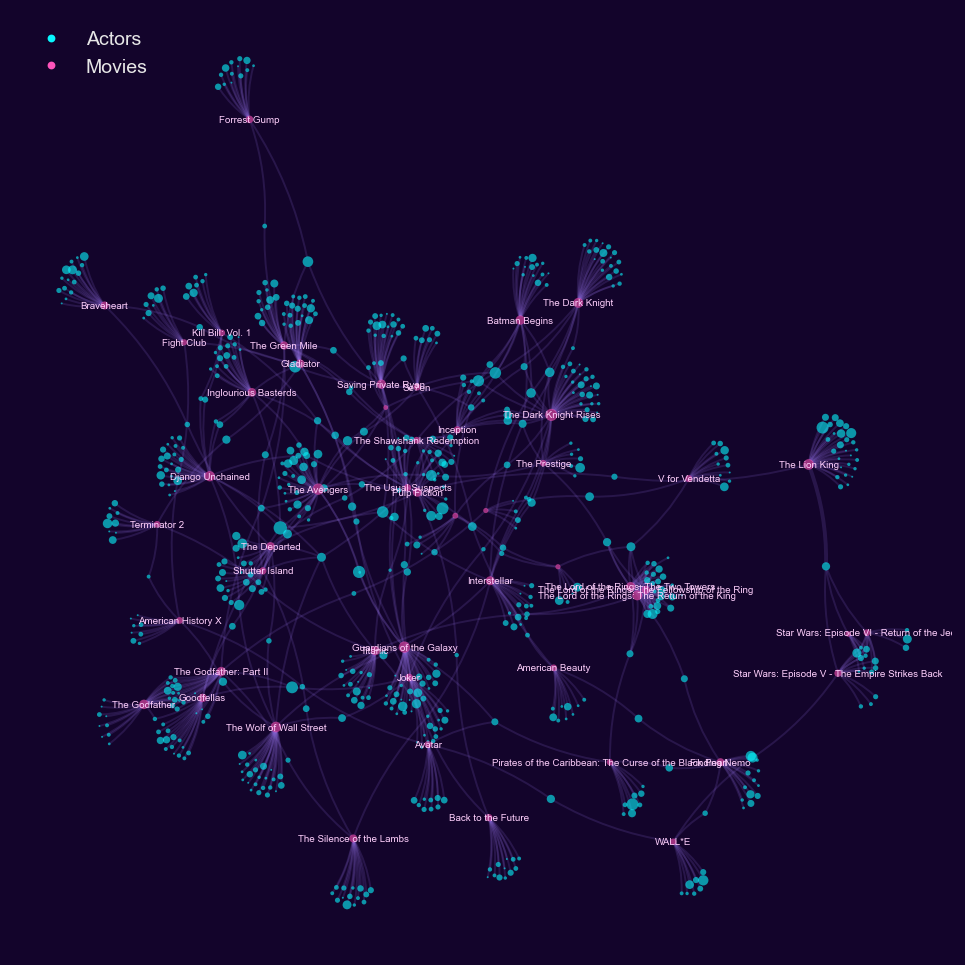

In [41]:
k_pos, k_actor_nodes, k_movie_nodes = create_pos(K, actors, random_seed, safe=False)
draw_graph_filtered(
    K,
    k_pos,
    nodes_list=[k_actor_nodes, k_movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    add_labels=True,
    min_sizes=[1, 1],  # Minimum size of nodes to be displayed
    min_sizes_labels=[100, 10],  # Minimum size of nodes to display labels
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=3,
)

This subgraph is already much clearer. Individual groups that are thematically related can already be identified. For example, we have the Star Wars and Lord of the Rings movies very close together. The Quentin Tarantino movies are mostly together and so are many films in which Leonardo DiCaprio has starred. We have a very strongly connected center with some outsiders connected by individual actors. Presumably these outsiders are connected to the center through other films, but we have filtered these out. However, these "bridges" between the films are exactly our goal. And if we manage to find them in this subgraph, hopefully we can apply this approach to the whole dataset.

In [42]:
def graph_metrics(G):
    results = dict()
    results["density"] = nx.density(G)
    results["diameter"] = nx.diameter(G)
    results["avg_shortest_path_length"] = nx.average_shortest_path_length(G)
    results["local_efficiency"] = nx.local_efficiency(G)
    results["global_efficiency"] = nx.global_efficiency(G)
    results["transitivity"] = nx.transitivity(G)
    results["avg_clustering"] = nx.average_clustering(G)
    results["correlation_coefficient"] = nx.degree_pearson_correlation_coefficient(G)
    results["non-randomness"] = nx.non_randomness(G)
    return results

Before we look for these roles, we will examine some properties of our graph.

In [43]:
G0.number_of_nodes(), G0.number_of_edges()

(8540, 26088)

Compared to GCC, the subgraph has fewer nodes, which is logical with less data. However, it has relatively fewer edges. While the GCC's ratio of nodes to edges was ~1:3, the subgraph's ratio is almost 1:1.

In [44]:
K_nodes = K.number_of_nodes()
K_edges = K.number_of_edges()
K_nodes, K_edges

(735, 884)

This ratio cannot be represented by a random graph, if it is to be strongly connected. Only a ratio similar to the GCC can be mapped.

In [45]:
random_G = nx.erdos_renyi_graph(K_nodes, 0.01, seed=random_seed, directed=False).to_undirected()
random_G.number_of_nodes(), random_G.number_of_edges()

(735, 2713)

In [46]:
random_G_list = list()
random_seeds_list = [random_seed, *random.sample(range(0, 99999), 10)]
random_seeds_list_final = list()
for seed in tqdm(random_seeds_list):
    try:
        _random_G = nx.erdos_renyi_graph(K_nodes, 0.01, seed=seed, directed=False).to_undirected()
        random_G_list.append(graph_metrics(_random_G))
        random_seeds_list_final.append(seed)
    except nx.NetworkXError as e:
        print(e)

  0%|          | 0/11 [00:00<?, ?it/s]

Found infinite path length because the graph is not connected
Found infinite path length because the graph is not connected
Found infinite path length because the graph is not connected
Found infinite path length because the graph is not connected
Found infinite path length because the graph is not connected


In [47]:
metrics_df = pd.DataFrame(
    [graph_metrics(K), *random_G_list],
    index=[f"Top{n_votes}", *random_seeds_list_final],
)
metrics_df

density  diameter  avg_shortest_path_length  local_efficiency  \
Top50  0.003277        12                  6.335695          0.000000   
42     0.010058         6                  3.523224          0.009800   
73686  0.010176         6                  3.512043          0.011217   
98331  0.010313         6                  3.484936          0.009708   
9705   0.009976         6                  3.533296          0.010915   
14440  0.010095         6                  3.519094          0.011226   
1150   0.010058         6                  3.525882          0.008113   

       global_efficiency  transitivity  avg_clustering  \
Top50           0.179789      0.000000        0.000000   
42              0.302555      0.010211        0.009385   
73686           0.303773      0.010924        0.010978   
98331           0.305885      0.009640        0.009577   
9705            0.301623      0.010112        0.010665   
14440           0.302903      0.010771        0.010910   
1150            0.302357      0.008438        0.007973   

       correlation_coefficient                            non-randomness  
Top50                -0.737913  (-87.26453867614715, -69.91651241202476)  
42                   -0.028767   (8.455336484086736, 0.5887550512654993)  
73686                 0.003502   (8.651817262041595, 1.3570033712444975)  
98331                -0.016960    (8.72067433619102, 1.1262729751334855)  
9705                 -0.021517     (8.3721085259512, 0.4243144873551806)  
14440                 0.009419   (8.494675993993237, 0.6737393735715759)  
1150                  0.012374    (8.482410184245575, 0.780612855229612)

---
<a id='exp'></a>

## 2. Experiments

<a id='noderoles'></a>
### 2.1. Node-Roles


For the node roles we will calculate different node metrics. Most interesting for us are the node strength and betweenness. 

In [48]:
node_strength = dict(K.degree(weight="weight"))
betweenness = nx.betweenness_centrality(K)

index_cols = ["betweenness", "node_strength"]
df_analysis = pd.DataFrame([betweenness, node_strength], index=index_cols).T
for col in index_cols:
    df_analysis[f"{col}_rank"] = df_analysis[col].rank(ascending=False)

In [49]:
df_analysis.nlargest(10, "betweenness")

betweenness  node_strength  betweenness_rank  \
Leonardo DiCaprio           0.195280            6.0               1.0   
The Avengers                0.182183           34.0               2.0   
Pulp Fiction                0.140000           21.0               3.0   
Guardians of the Galaxy     0.131095           34.0               4.0   
Titanic                     0.130322           22.0               5.0   
Samuel L. Jackson           0.126805            5.0               6.0   
Django Unchained            0.117874           28.0               7.0   
The Dark Knight Rises       0.109959           39.0               8.0   
The Departed                0.103440           18.0               9.0   
Saving Private Ryan         0.101261           23.0              10.0   

                         node_strength_rank  
Leonardo DiCaprio                      51.0  
The Avengers                            2.5  
Pulp Fiction                           16.0  
Guardians of the Galaxy                 2.5  
Titanic                                14.0  
Samuel L. Jackson                      54.5  
Django Unchained                        6.0  
The Dark Knight Rises                   1.0  
The Departed                           21.5  
Saving Private Ryan                    11.5

Since we are only interested in the actors, we have to filter out the movies from the DataFrame.

In [50]:
movies = df_pop["Film"].unique().tolist()
df_analysis_actors = df_analysis[~df_analysis.index.isin(movies)]
df_analysis_actors.nlargest(10, "betweenness")

betweenness  node_strength  betweenness_rank  \
Leonardo DiCaprio      0.195280            6.0               1.0   
Samuel L. Jackson      0.126805            5.0               6.0   
Phil LaMarr            0.085964            2.0              16.0   
Michael Caine          0.073575            6.0              21.0   
Harry Dean Stanton     0.066715            3.0              25.0   
Matt Damon             0.060633            3.0              27.0   
Morgan Freeman         0.056304            5.0              33.0   
Zoe Saldana            0.053606            3.0              34.0   
Bernard Hill           0.053347            3.0              36.0   
John Ratzenberger      0.045769            3.0              39.0   

                    node_strength_rank  
Leonardo DiCaprio                 51.0  
Samuel L. Jackson                 54.5  
Phil LaMarr                      141.0  
Michael Caine                     51.0  
Harry Dean Stanton                77.5  
Matt Damon                        77.5  
Morgan Freeman                    54.5  
Zoe Saldana                       77.5  
Bernard Hill                      77.5  
John Ratzenberger                 77.5

We use those two metrics to find the potential intermediaries.

First, we take the 20 actors with the highest betweenness score and plot their names on our graph.

In [51]:
ambassadors = list(df_analysis_actors.nlargest(20, "betweenness").index)
ambassadors = {actor: actor for actor in ambassadors}

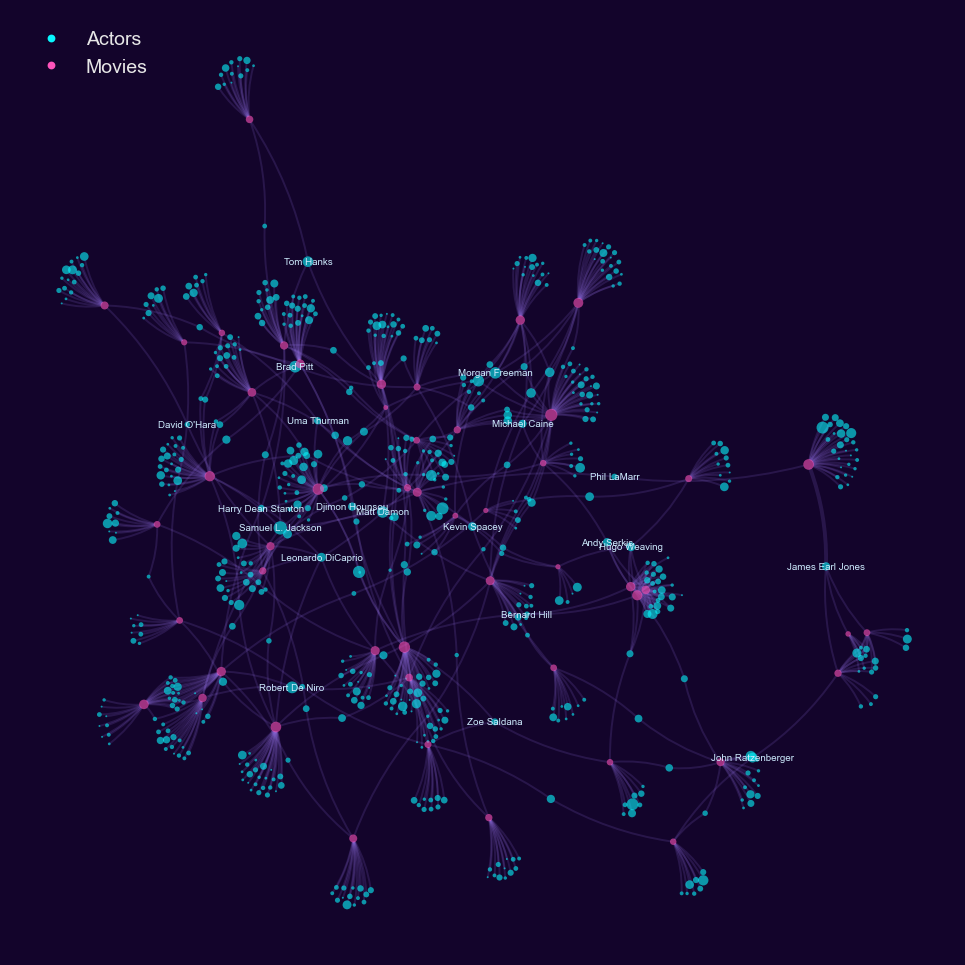

In [52]:
draw_graph_filtered(
    K,
    k_pos,
    nodes_list=[k_actor_nodes, k_movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    add_labels=True,
    min_sizes=[1, 1],  # Minimum size of nodes to be displayed
    min_sizes_labels=[100, 100],  # Minimum size of nodes to display labels
    nodes_labels_list=[ambassadors, None],  # Custom labels to overwrite size filter
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=3,
)

The actors John Ratzenberger, James Earl Jones, Phil LaMarr and Djimon Hounsou are recognized as links between films. However, many actors are also pointed out who simply appear in many films. This info is of course also interesting, but not what we are looking for. This metric is not suited for our goal.

So next we take the 20 actors with the highest node_strength score and plot their names on our graph.

In [53]:
strong = list(df_analysis_actors.nlargest(20, "node_strength").index)
strong = {actor: actor for actor in strong}

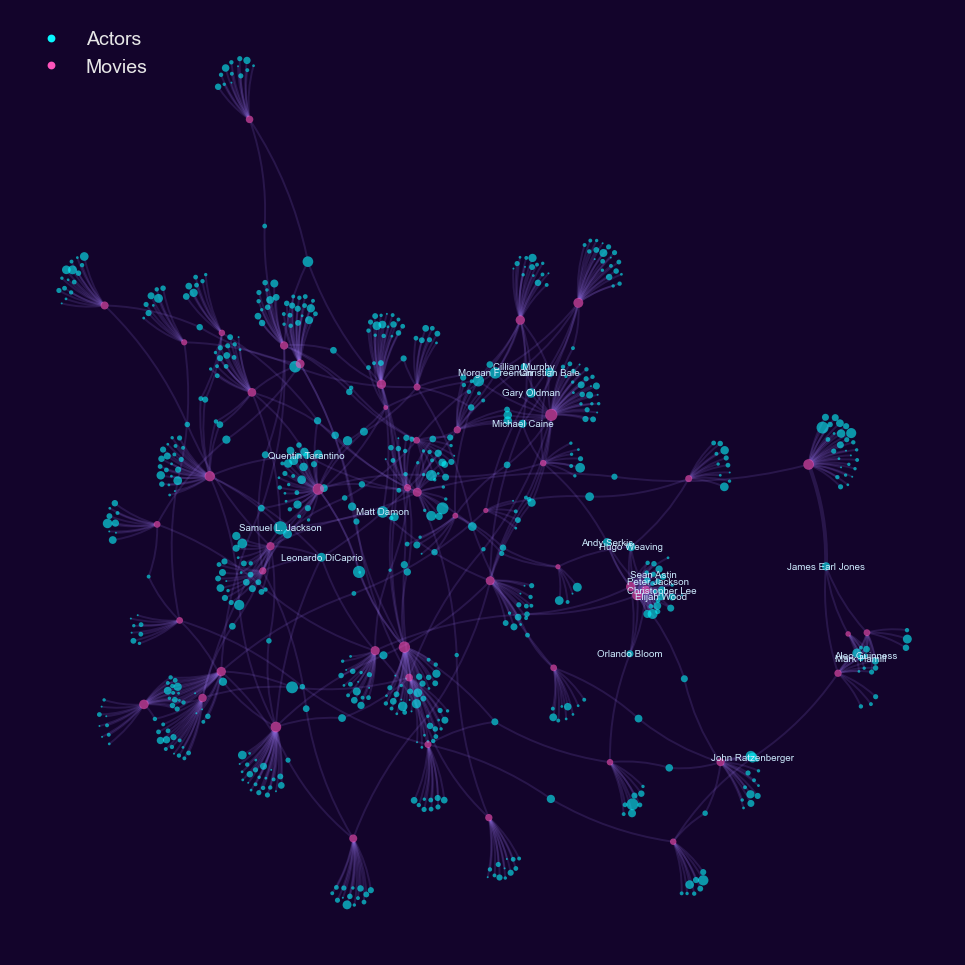

In [54]:
draw_graph_filtered(
    K,
    k_pos,
    nodes_list=[k_actor_nodes, k_movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    add_labels=True,
    min_sizes=[1, 1],  # Minimum size of nodes to be displayed
    min_sizes_labels=[100, 100],  # Minimum size of nodes to display labels
    nodes_labels_list=[strong, None],  # Custom labels to overwrite size filter
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=3,
)

Here we get John Ratzenberger and James Earl Jones again. But none of the other links are selected. We mostly got famous actors such as Leonardo DiCaprio, Samuel L. Jackson, Matt Damon, Orlando Bloom, Liam Neeson and Carrie Fisher. Not the actors we are looking for.


As a final approach, we consider the shortest distance between nodes. More precisely, the shortest distance between two different movies with only one actor in between. For this we calculate the shortest distance between all movie combinations.

In [55]:
k_movies = [node for node in K.nodes if node in movies]
k_movie_pairs = list(itertools.combinations(k_movies, 2))

shortest_paths = [nx.shortest_path(K, pair[0], pair[1]) for pair in k_movie_pairs]

Then, we filter all paths that are longer than 3. Because we are only interested in actors between movies.

In [56]:
shortest_paths[0]

['The Departed',
 'Leonardo DiCaprio',
 'Titanic',
 'Jenette Goldstein',
 'Terminator 2']

In [57]:
shortest_shortest_paths = [path for path in shortest_paths if len(path) <= 3]
connector_actors = set([path[1] for path in shortest_shortest_paths])
connectors = {actor: actor for actor in connector_actors}

We then plot the names of all these actors in our graph.

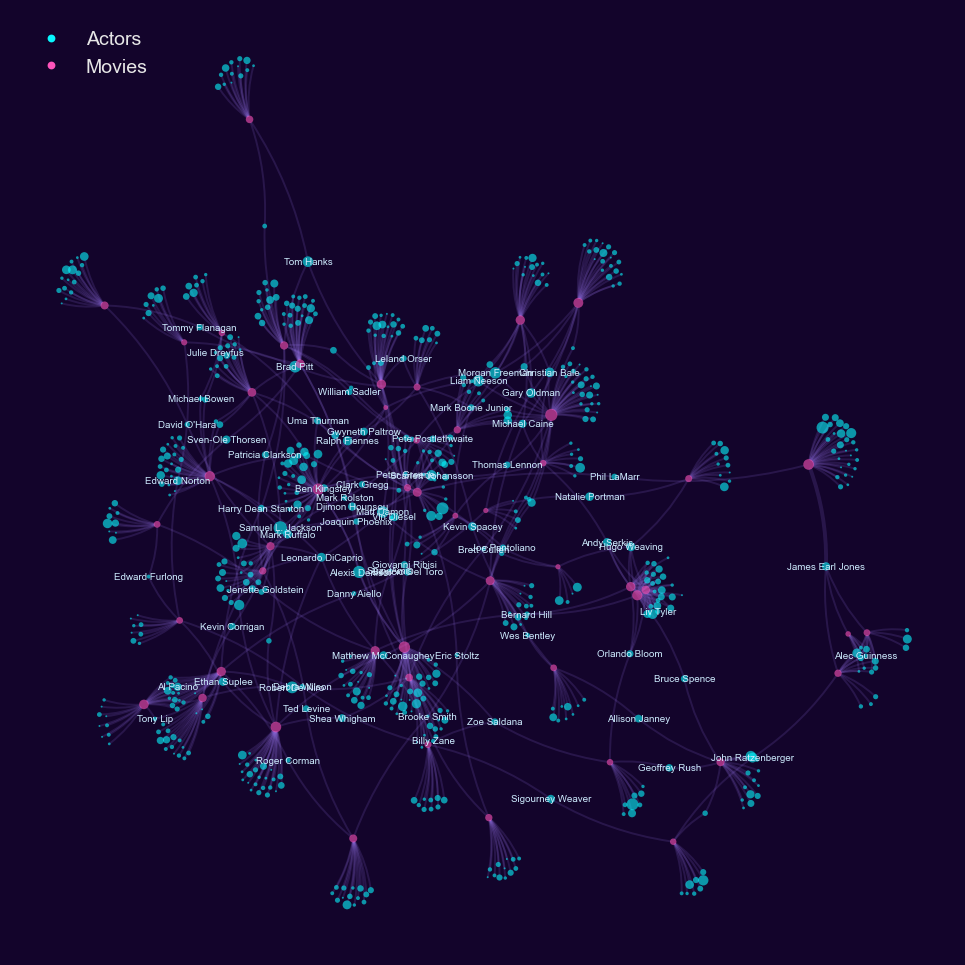

In [58]:
draw_graph_filtered(
    K,
    k_pos,
    nodes_list=[k_actor_nodes, k_movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    add_labels=True,
    min_sizes=[1, 1],  # Minimum size of nodes to be displayed
    min_sizes_labels=[100, 100],  # Minimum size of nodes to display labels
    nodes_labels_list=[connectors, None],  # Custom labels to overwrite size filter
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=3,
)

Now we have found all the intermediaries between all the films. But now we have the problem that we have all the intermediaries. But we are only interested in intermediaries between franchises. Therefore, the next step is to recognize the franchises as such. For this we try to discover communities.

<a id='comdis'></a>

### 2.2. Community-Discovery

For the community discovery task we use four different approaches. We then filter the intermediaries that are between two communities.

<a id='221'></a>
#### 2.2.1 Louvain Community Detection

In [59]:
def create_node_colors(communities):
    return {node: f"C{idx}" for idx, area in enumerate(communities) for node in area}

In [60]:
communities_louvain = nx_comm.louvain_communities(K, seed=random_seed)
node_color_dict_comm = create_node_colors(communities_louvain)

<a id='222'></a>
#### 2.2.2. Modularity-based communities

In [61]:
communities_greedy = nx_comm.greedy_modularity_communities(K)
node_color_dict_greedy = create_node_colors(communities_greedy)

<a id='223'></a>
#### 2.2.3. Fluid Communities

In [62]:
communities_fluid = nx_comm.asyn_fluidc(K, k=5)
node_color_dict_fluid = create_node_colors(communities_fluid)

<a id='224'></a>
#### 2.2.4. Girvan-Newman Communities

In [63]:
communities_girvan = nx_comm.girvan_newman(K)
next(communities_girvan)
second_girvan = next(communities_girvan)
node_color_dict_girvan = create_node_colors(second_girvan)

Using the communities we filter the intermediaries so that we only have those that are located between two different communities.

In [64]:
def filter_path(shortest_path: list[str, str, str], communities: dict) -> list[str, str, str]:
    if communities[shortest_path[0]] != communities[shortest_path[2]]:
        return shortest_path
    return None

In [65]:
def create_community_connectors(community: dict, shortest_paths: list[list[str, str, str]]) -> dict:
    shortest_paths_none = [filter_path(path, community) for path in shortest_paths]
    shortest_paths_nonone = [path for path in shortest_paths_none if path is not None]
    connector_actors = set([path[1] for path in shortest_paths_nonone])
    return {actor: actor for actor in connector_actors}

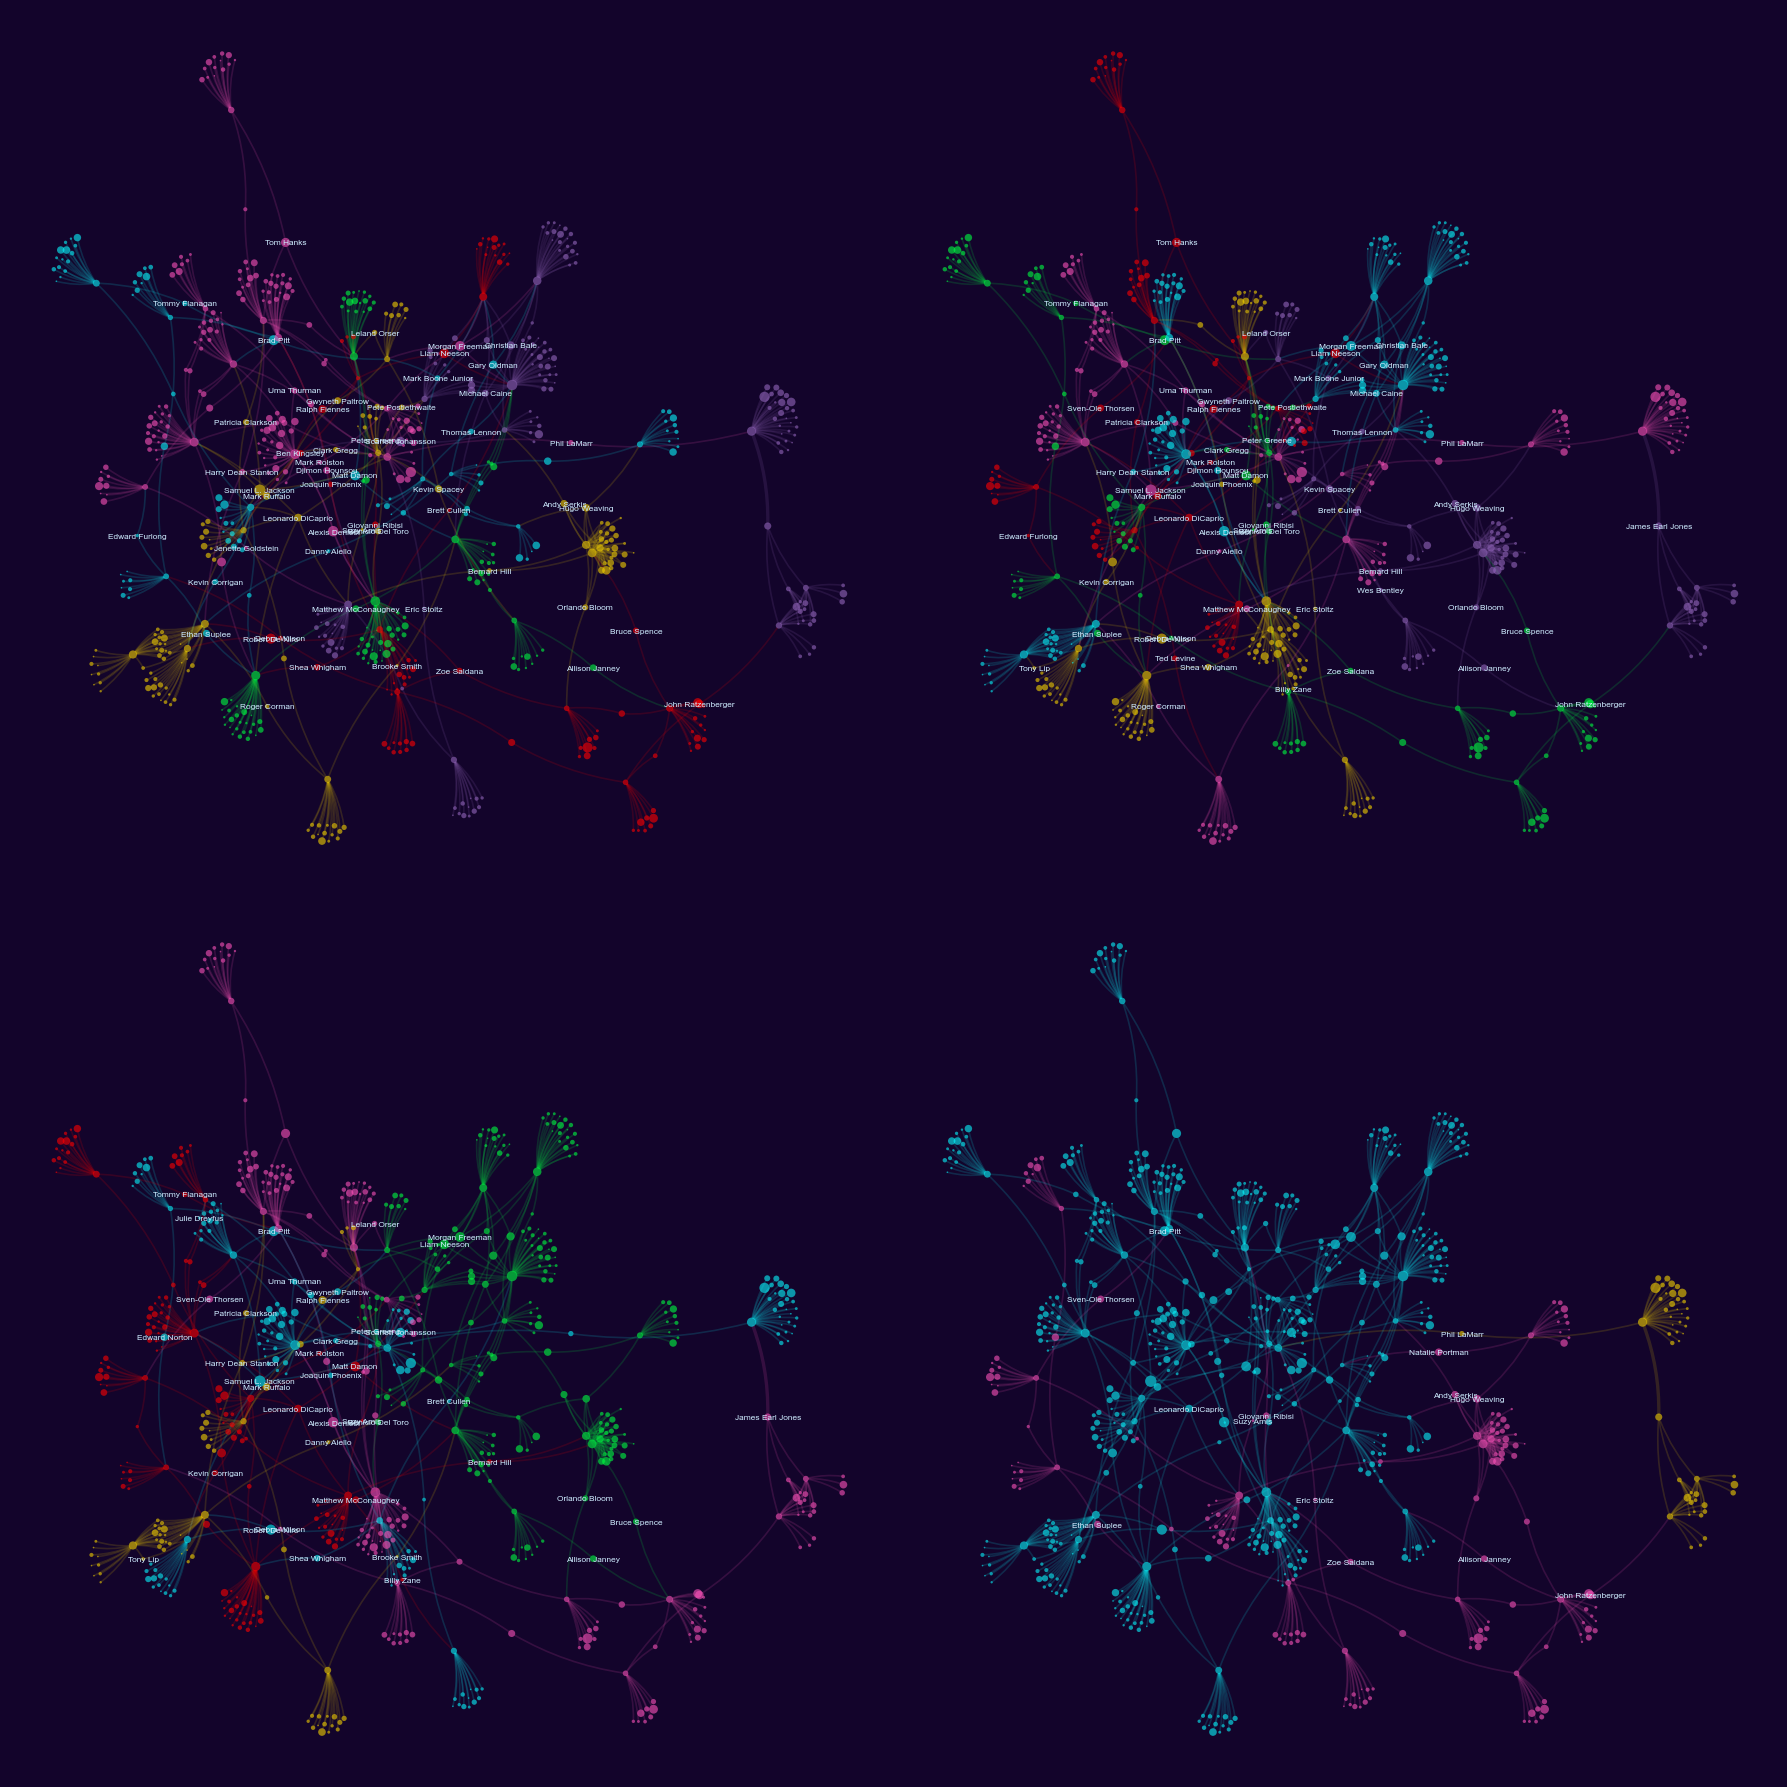

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
col, row = 0, 0
for color_dict in [
    node_color_dict_comm,
    node_color_dict_greedy,
    node_color_dict_fluid,
    node_color_dict_girvan,
]:
    connectors = create_community_connectors(color_dict, shortest_shortest_paths)
    face_color = draw_graph_filtered(
        K,
        k_pos,
        ax=axes[row, col],
        nodes_list=[k_actor_nodes, k_movie_nodes],
        nodes_sizes_list=[actors_sizes, movies_sizes],
        add_labels=True,
        min_sizes=[1, 1],  # Minimum size of nodes to be displayed
        min_sizes_labels=[100, 100],  # Minimum size of nodes to display labels
        nodes_labels_list=[connectors, None],  # Custom labels to overwrite size filter
        node_colors=color_dict,
    )
    col += 1
    if col == 2:
        col = 0
        row += 1
plt.gcf().set_facecolor(face_color)
plt.show()

Based on the visual differences, the Louvain Community Detection method in the top left corner appears to create the most reasonable communities.

---
<a id='results'></a>

## 3. Results


In [67]:
def create_community_connectors_with_movie(
    community: dict, shortest_paths: list[list[str, str, str]]
) -> list:
    shortest_paths_none = [filter_path(path, community) for path in shortest_paths]
    return [path for path in shortest_paths_none if path is not None]

In [68]:
final_communities = node_color_dict_comm

In [69]:
connectors = create_community_connectors(final_communities, shortest_shortest_paths)
connectors_df = create_community_connectors_with_movie(final_communities, shortest_shortest_paths)
best_connectors = pd.DataFrame(connectors_df, columns=["Source", "Actor", "Target"])

In [70]:
best_connectors[best_connectors["Actor"].isin(["Phil LaMarr", "John Ratzenberger", "Bruce Spence"])]

Source              Actor  \
27                                          WALL*E  John Ratzenberger   
39   The Lord of the Rings: The Return of the King       Bruce Spence   
72  Star Wars: Episode V - The Empire Strikes Back  John Ratzenberger   
75                                    Pulp Fiction        Phil LaMarr   

                                            Target  
27  Star Wars: Episode V - The Empire Strikes Back  
39                                    Finding Nemo  
72                                    Finding Nemo  
75                                   The Lion King

If we connect the communities with our connectors we get a list of all potential intermediaries connecting different communities. These are all potential actors who are the only link between two or more franchises. 
For example Phil LaMarr and John Ratzenberger are both the link between the Star Wars/Lion King (Disney) franchise and Pulp Fiction and WALL-E/Finding Nemo (Disney) respectively. Bruce Spence is another link from Finding Nemo to the Lord of the Rings franchise.

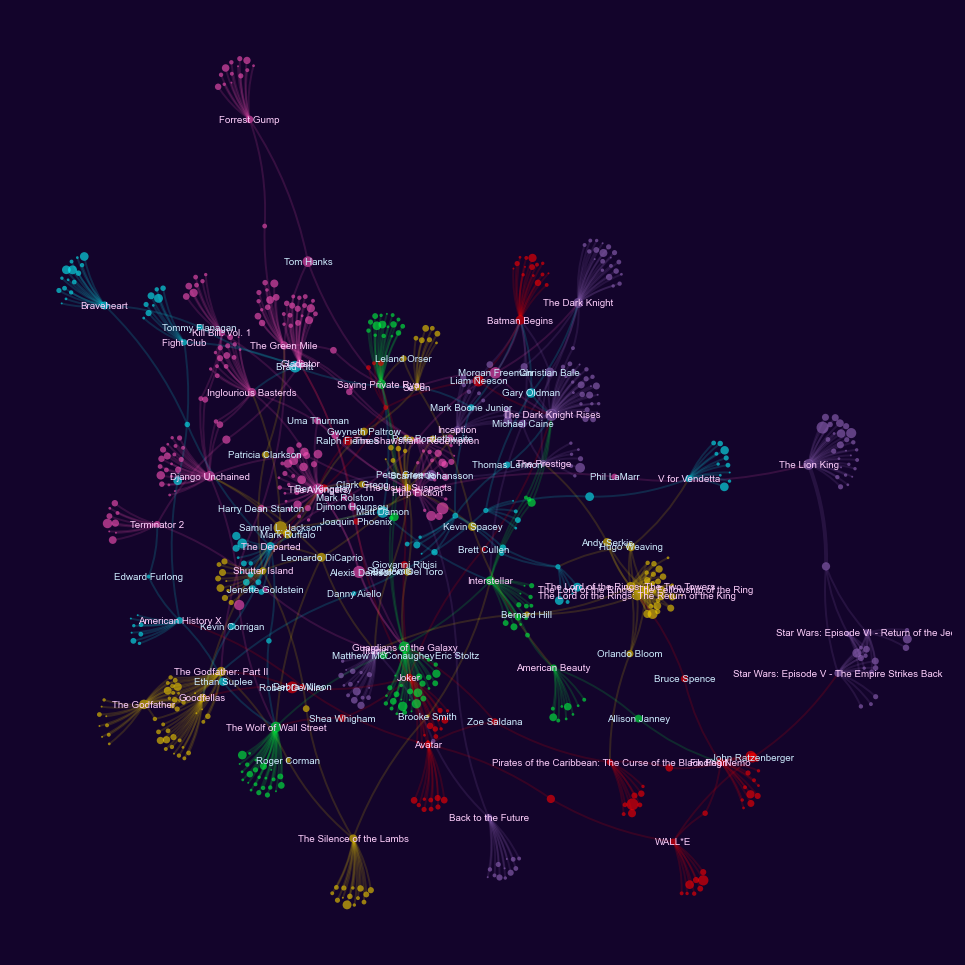

In [71]:
draw_graph_filtered(
    K,
    k_pos,
    nodes_list=[k_actor_nodes, k_movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    add_labels=True,
    min_sizes=[1, 1],  # Minimum size of nodes to be displayed
    min_sizes_labels=[100, 10],  # Minimum size of nodes to display labels
    nodes_labels_list=[connectors, None],  # Custom labels to overwrite size filter
    node_colors=final_communities,
)

Next, these potential connectors need to be explored further. How well known are the actors? Do these actors have enough fans that their appearance in the next movie is noticed in the tickets sold?

In the end, we were able to show that it is relatively easy to find the people we are looking for. The biggest challenge is determining the communities.

Further research questions:
- How accurate are the communities?
- Is there another way to discover these intermediaries?
- How does this approach relate to the entire data set?

---
<a id='ref'></a>

## References

<p> [1] https://www.kaggle.com/datasets/darinhawley/imdb-films-by-actor-for-10k-actors